# LightAutoML: Interpretation Tutorial

Some of HTML static content is not loading, to solve this problem you can use [nbviewer](https://nbviewer.jupyter.org). Link on tutorial on nbviever [here](https://nbviewer.jupyter.org/github/sberbank-ai-lab/LightAutoML/blob/pooling_fix/Tutorial_5.%20NLP%20Interpretation.ipynb).

The last years deep neural networks / gradient boosting / ensembles of models allow to improve the soulution quality of many application task in field of natural language processing (NLP). The indicators of this improvement describe the partial behavior of the model and can hide errors, for example, errors in the construction of the model, errors in data collection. All this can be critical in tasks related to the processing of medical, forensic, banking data.
In this tutorial we will check the NLP interpetation module of automl.

## Download library and make some imports

In [1]:
# !pip install lightautoml

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import LimeTextExplainer

import transformers
transformers.logging.set_verbosity(50)

## Dowload data

For this tutorial we will use train dataset (train.csv) from [Jigsaw-Toxic-Comment-Classification-Challage](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview). The dataset contains  textual comments and 6 attributes of this text (toxic, serve_toxic, obscene, treat, insult, identity_hate). For now, we will use only <i>toxic</i> attribute.

In [3]:
# train.csv file from
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

data = pd.read_csv('train.csv')
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Usage of AutoML 

We will use standard ``lightautoml.automl.presets.text_presets.TabularNLPAutoML`` preset with finetuned TinyBERT from [Hugging Face](https://huggingface.co).

In [4]:
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42)

roles = {
    'text': ['comment_text'], 
    'drop': ['id', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    'target': 'toxic'
}

task = Task('binary')

automl = TabularNLPAutoML(
    task=task,
    timeout=3600,
    cpu_limit=1,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn']]
    },
    autonlp_params={
        'sent_scaler': 'l2'
    },
    text_params={
        'lang': 'en',
        'bert_model': 'prajjwal1/bert-tiny'
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    },
    verbose=2
)

oof_pred = automl.fit_predict(train, roles=roles)
test_pred = automl.predict(test)
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print('Check scores:')
print('OOF score: {}'.format(roc_auc_score(train[roles['target']].values[not_nan], oof_pred.data[not_nan][:, 0])))
print('TEST score: {}'.format(roc_auc_score(test[roles['target']].values, test_pred.data[:, 0])))

Model language mode: en
Start automl preset with listed constraints:
- time: 3600 seconds
- cpus: 1 cores
- memory: 16 gb

Train data shape: (127656, 8)


Layer 1 ...
Train process start. Time left 3599.8790543079376 secs
Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.30it/s]

Epoch: 0, train loss: 0.2570450007915497, val loss: 0.19485096633434296, val metric: 0.9637836876016782



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.33it/s]

Epoch: 1, train loss: 0.16872628033161163, val loss: 0.14495356380939484, val metric: 0.9713542494872768



val: 100%|██████████| 1330/1330 [01:06<00:00, 19.93it/s]

Epoch: 2, train loss: 0.13151153922080994, val loss: 0.12280727922916412, val metric: 0.9747751993810625



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.14it/s]

Epoch: 3, train loss: 0.11367320269346237, val loss: 0.1126171126961708, val metric: 0.9765513956674373



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.20it/s]

Epoch: 4, train loss: 0.1027149185538292, val loss: 0.10632816702127457, val metric: 0.977796992159309



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.18it/s]

Epoch: 5, train loss: 0.09626304358243942, val loss: 0.10376758873462677, val metric: 0.9785787008580725



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.11it/s]

Epoch: 6, train loss: 0.09030253440141678, val loss: 0.1034480407834053, val metric: 0.9788737906916769



===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:06<00:00, 20.04it/s]

Epoch: 0, train loss: 0.25809404253959656, val loss: 0.19568908214569092, val metric: 0.9628246754519126



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.82it/s]

Epoch: 1, train loss: 0.17004330456256866, val loss: 0.1436380296945572, val metric: 0.9712892929811795



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.83it/s]

Epoch: 2, train loss: 0.1328740119934082, val loss: 0.1212274506688118, val metric: 0.9752712916851096



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.78it/s]

Epoch: 3, train loss: 0.11425625532865524, val loss: 0.11091475933790207, val metric: 0.9771619079823601



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.65it/s]

Epoch: 4, train loss: 0.10420488566160202, val loss: 0.10691312700510025, val metric: 0.9783463079117893



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.77it/s]

Epoch: 5, train loss: 0.09668266773223877, val loss: 0.10273038595914841, val metric: 0.978979559261725



val: 100%|██████████| 1330/1330 [01:07<00:00, 19.66it/s]

Epoch: 6, train loss: 0.09077204763889313, val loss: 0.10302633047103882, val metric: 0.9793691977461714



val: 100%|██████████| 1330/1330 [01:06<00:00, 19.99it/s]

Early stopping: val loss: 0.10273038595914841, val metric: 0.978979559261725



===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_TorchNN =====



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.25it/s]


Epoch: 0, train loss: 0.2581411302089691, val loss: 0.19450736045837402, val metric: 0.9639252648579809


val: 100%|██████████| 1330/1330 [01:06<00:00, 20.06it/s]

Epoch: 1, train loss: 0.1706278920173645, val loss: 0.1428082436323166, val metric: 0.970978252550365



val: 100%|██████████| 1330/1330 [01:05<00:00, 20.27it/s]


Epoch: 2, train loss: 0.13274139165878296, val loss: 0.1216595396399498, val metric: 0.9745216901092819


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.31it/s]


Epoch: 3, train loss: 0.1141367182135582, val loss: 0.11119359731674194, val metric: 0.9764433868724282


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.20it/s]


Epoch: 4, train loss: 0.10428732633590698, val loss: 0.1062881276011467, val metric: 0.9774170386217307


val: 100%|██████████| 1330/1330 [01:06<00:00, 19.96it/s]


Epoch: 5, train loss: 0.09581169486045837, val loss: 0.1043882891535759, val metric: 0.977735719335192


val: 100%|██████████| 1330/1330 [01:05<00:00, 20.24it/s]


Epoch: 6, train loss: 0.09032654762268066, val loss: 0.10361003130674362, val metric: 0.9784727676526263
Lvl_0_Pipe_0_Mod_0_TorchNN fitting and predicting completed
Time left -648.1437613964081


Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings



Automl preset training completed in 4248.15 seconds.


test: 100%|██████████| 998/998 [00:48<00:00, 20.41it/s]


Check scores:
OOF score: 0.977819000722559
TEST score: 0.9807768133435921


In [5]:
automl.set_verbosity_level(0) # refuse logging in automl

## LIME

Linear approximation of model nearby selected object. The weights of this linear model is feature attribution for automl's prediction for this object.

Algorithm:

0. Select object to interpret.

1. Select the input text column, that will be explained (```perturb_column```). All other columns of object will be fixed.

2. A dataset of size ```n_sample``` (by default ``5000``) is created by randomly deleting tokens (in groups). Dataset is binary (there is a token if one and no token if zero).

3. Predict with AutoML module target values for created dataset.

4. Optionally, the selection of features (important tokens) is performed using LASSO (```feature_selection='lasso'```, you can also ```'none'``` to not select and get them all). The number of features used after feature selection is ```n_feautres``` (```= 10``` by default).

5. We train the explained model on this (a linear model with weights, the method of calculating weights is the cosine distance by default, you can also use your own function or the name of the distance from ```sklearn.metrics.pairwise_distances```).

6. The weights of the linear model are the interpretation.

P.S. Care about the sentence length. Detokenization works within $O(n^2)$, where $n$ -- sentence length. 


Scheme of work:

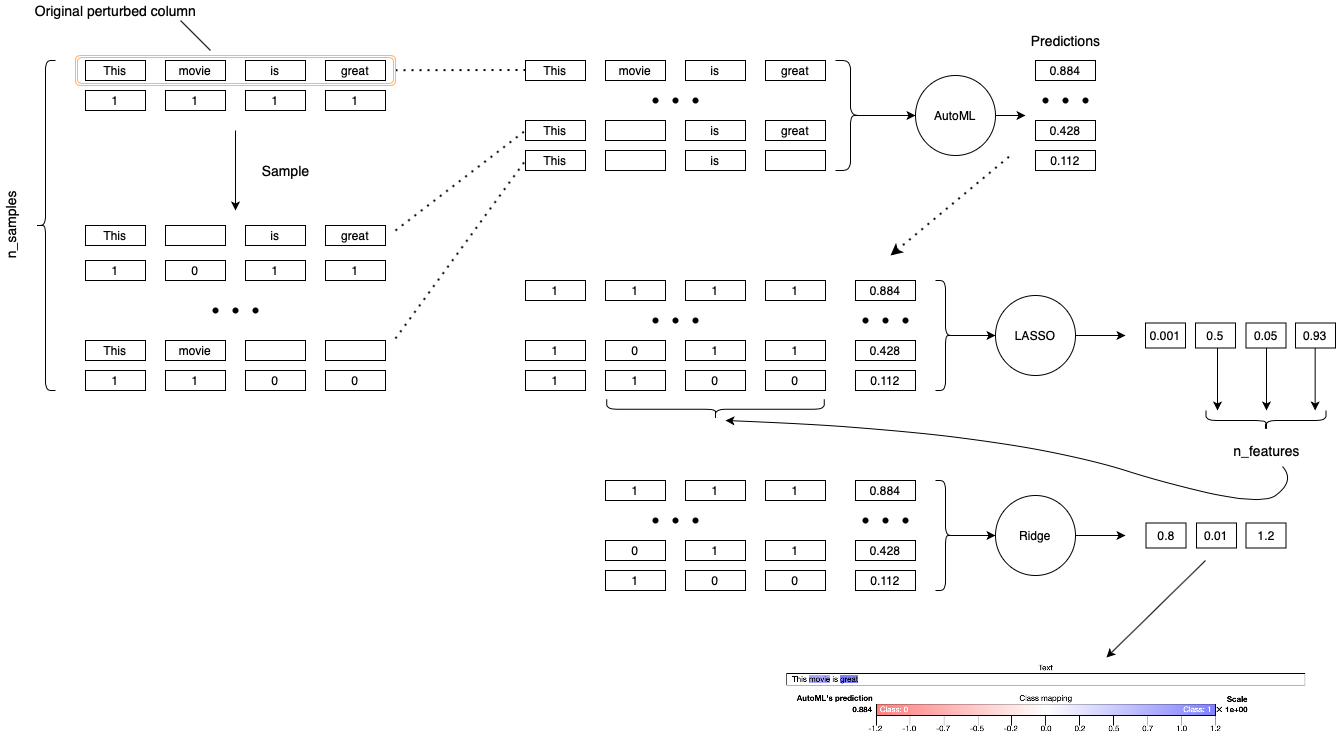

In [6]:
# LimeTextExplainer for NLP preset
lime = LimeTextExplainer(automl, feature_selection='lasso', force_order=False)

#### Let's try it on neutral text

In [7]:
exp = lime.explain_instance(test.loc[34019], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

Text
 
 
 The lyrics is found in the German version , so I assume it ' s usable . ~ 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -7.3 -5.9 -4.4 -2.9 -1.5 0.0 1.5 2.9 4.4 5.9 7.3 
 

 Scale 
 ✕ 1e-05 

 AutoML's prediction 
 0.003

#### Toxic comments

In [8]:
exp = lime.explain_instance(test.loc[78687], labels=(0, 1), perturb_column='comment_text')
exp.visualize_in_notebook(1)

Text
 
 
 A silly fat cow who won ' t leave me alone 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.2 -1.7 -1.3 -0.9 -0.4 0.0 0.4 0.9 1.3 1.7 2.2 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.908

#### Let's see on uncertain expamples

In [9]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more important to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.2 -0.9 -0.7 -0.5 -0.2 0.0 0.2 0.5 0.7 0.9 1.2 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.082

Let's delete 'important' from this abstract. We can see that automl increase it's probability of toxicity of this abstract

In [10]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ?'

In [11]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.1 -1.7 -1.2 -0.8 -0.4 0.0 0.4 0.8 1.2 1.7 2.1 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.277

If we add the 'relability' the AutoML decrease the toxicity probability.

In [12]:
test.loc[4733, 'comment_text'] = 'Why are you still here ? Can you not find anything more to do , like killing yourself ? relability'

In [13]:
exp = lime.explain_instance(test.loc[4733], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Why are you still here ? Can you not find anything more to do , like killing yourself ? relability 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.9 -1.5 -1.1 -0.7 -0.4 0.0 0.4 0.7 1.1 1.5 1.9 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.217

Another example

In [14]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 stop editing this , you dumbass . why do you have to be such a bitch ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -2.7 -2.2 -1.6 -1.1 -0.5 0.0 0.5 1.1 1.6 2.2 2.7 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.918

Let's delete the toxic words to 'good boy'

In [15]:
test.loc[40112, 'comment_text'] = "stop editing this, you good boy. why do you have to be such a good boy? the ghosts of bill maas' past will haunt you forever!!! MWAHAHHAHAA"

In [16]:
exp = lime.explain_instance(test.loc[40112], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 stop editing this , you good boy . why do you have to be such a good boy ? the ghosts of bill maas ' past will haunt you forever !!! MWAHAHHAHAA 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.5 -1.2 -0.9 -0.6 -0.3 0.0 0.3 0.6 0.9 1.2 1.5 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.164

Let's try from neutral make toxic abstract.

In [17]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -1.2 -1.0 -0.7 -0.5 -0.2 0.0 0.2 0.5 0.7 1.0 1.2 
 

 Scale 
 ✕ 1e-03 

 AutoML's prediction 
 0.003

In [18]:
test.loc[18396] = "Okay , thanks . I will do so . dumbass please"

In [19]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -8.3 -6.6 -5.0 -3.3 -1.7 0.0 1.7 3.3 5.0 6.6 8.3 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.788

Adding some happy words

In [20]:
test.loc[18396] = "Okay , thanks . I will do so . happy dumbass please"

In [21]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . happy dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -7.6 -6.1 -4.6 -3.1 -1.5 0.0 1.5 3.1 4.6 6.1 7.6 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.652

More happy words.

In [22]:
test.loc[18396] = "Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please"

In [23]:
exp = lime.explain_instance(test.loc[18396], labels=(0, 1), perturb_column='comment_text', n_features=20) 
exp.visualize_in_notebook(1)

Text
 
 
 Okay , thanks . I will do so . happy cheerful joyfull glorious elated dumbass please 
 
 
 
 Class mapping
 
 
 
 
 Class: 0
 
 Class: 1
 
 
 

 
 -5.9 -4.7 -3.5 -2.3 -1.2 0.0 1.2 2.3 3.5 4.7 5.9 
 

 Scale 
 ✕ 1e-01 

 AutoML's prediction 
 0.325